In [1]:
from social_network import SocialNetwork
from logic_matrix import LogicMatrix
from init_belief import InitialBelief

import numpy as np
import matplotlib.pyplot as plt

In [2]:
agent_num = 30
topic_num = 3
seed = 1942340
T = 20


=== Social Network Summary ===
Nodes (n): 30
Directed: True
Model: RR
Beta(α,β): (3.3, 4.125)
Matrix shape: (30, 30)
Density (non-zero ratio): 0.117
Average row sum: 1.000
Average degree: 5.000
Average clustering: 0.140
Spectral radius (ρ): 1.000000
Second largest eigenvalue: 0.709814
Stability: Semi-stable (row-stochastic)
Random seed: 1942340



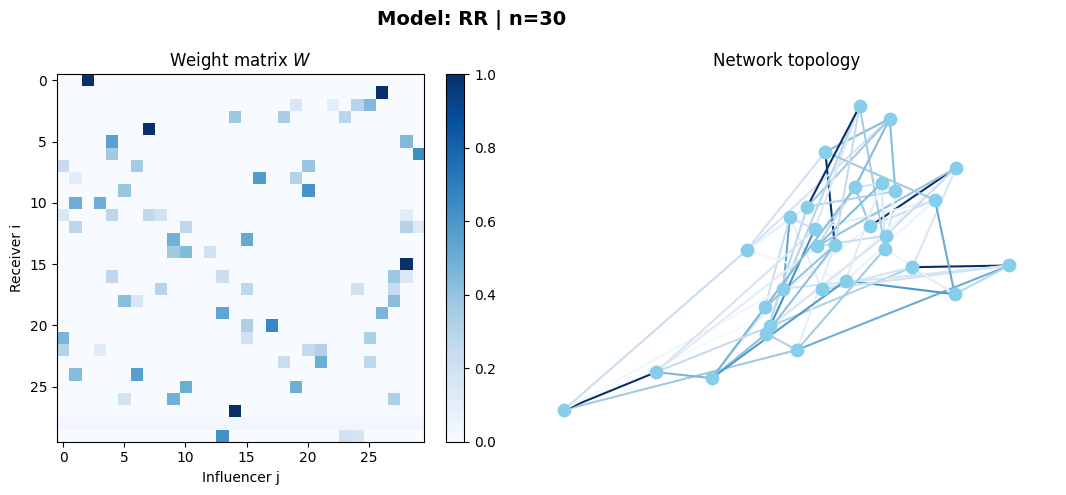

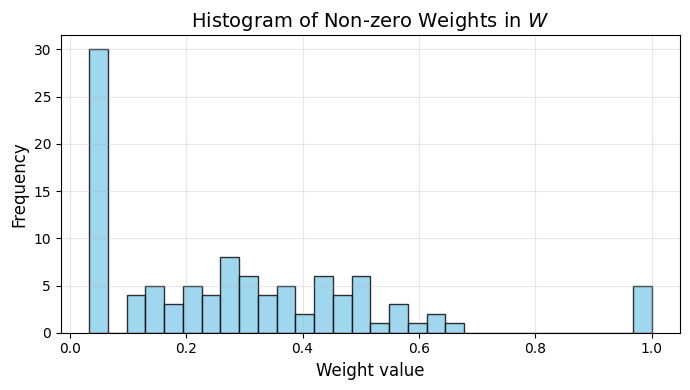

In [3]:
W = SocialNetwork(
    n=agent_num,
    random_beta=True,
    model="RR",
    seed=seed
).generate()

W_matrix = W.W
W.describe()
W.visualize()
W.plot_hist()

In [ ]:
C = LogicMatrix(
    n=agent_num,
    m=topic_num,
    random_beta=True,
    seed=seed
).generate()

C_base = C.C_base
C_tensor = np.array(C.C_list)   # shape: (n, m, m)

C.describe()
print(f'Base Logic Matrix:\n{C_base}')


=== Logic Matrix Summary ===
Agents (n): 30
Topics (m): 3
Beta(α,β): (3.3, 4.125)
Heterogeneity: 0.20
Non-zero ratio: 0.667
Average off-diagonal weight: 0.188
Seed: 1942340

Base Logic Matrix:
[[ 1.          0.          0.        ]
 [ 0.44028457  0.55971543  0.        ]
 [ 0.22257151 -0.18201515  0.59541334]]


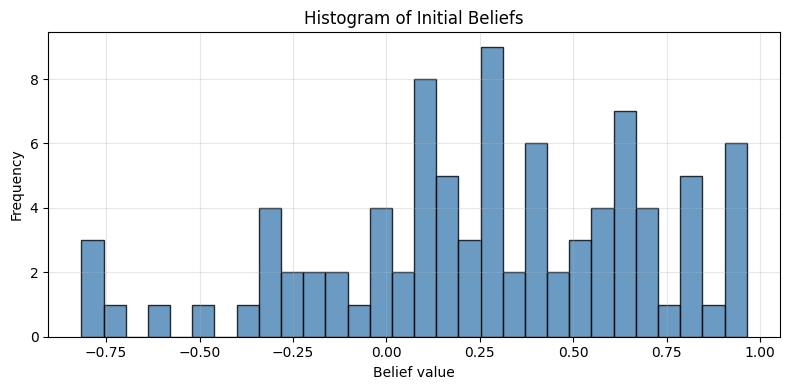

In [5]:
X0 = InitialBelief(
    n=agent_num,
    m=topic_num,
    mode="agent_uniform",
    agent_range="random"
).generate()

X0.plot_hist()
X0_vector = X0.X0


In [7]:
def simulate(W, C, X0, T=30, lam=0.8, 
             tol=1e-4, min_iter=5, patience=3,
             verbose=True):
    
    X = X0.copy()
    traj = [X]

    stable_steps = 0
    step_count = 0   # ⭐ 用来记录实际迭代次数

    for t in range(T):
        influence = W @ X
        blended = lam * influence + (1 - lam) * X
        X_next = np.einsum("nij,nj->ni", C, blended)

        traj.append(X_next)
        step_count = t + 1  # ⭐ 更新步长

        # # ---- Early stopping ----
        # if t >= min_iter:
        #     delta = np.max(np.abs(X_next - X))
        #     if delta < tol:
        #         stable_steps += 1
        #     else:
        #         stable_steps = 0

        #     if stable_steps >= patience:
        #         if verbose:
        #             print(f"Early stop at step {step_count} (Δ={delta:.2e})")
        #         break

        X = X_next

    return np.array(traj)


In [8]:
def plot_trajectories(trajectory, m):
    """绘制类似 Science 风格，但 Y 轴为 [-1,1] 的信念轨迹图"""
    n = trajectory.shape[1]
    time_axis = np.arange(trajectory.shape[0])

    # -----------------------
    # 全局风格
    # -----------------------
    plt.rcParams.update({
        "font.size": 12,
        "axes.linewidth": 1.2,
        "xtick.major.width": 1,
        "ytick.major.width": 1
    })

    fig, axes = plt.subplots(m, 1, figsize=(10, 15), sharex=True)

    if m == 1:
        axes = [axes]

    for topic in range(m):
        ax = axes[topic]

        # 画轨迹
        for agent in range(n):
            ax.plot(time_axis,
                    trajectory[:, agent, topic],
                    lw=1,
                    alpha=0.85)

        # ⭐ y 范围设为 [-1, 1]
        ax.set_ylim(-1, 1)
        ax.set_yticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 网格
        ax.grid(True, linestyle='-', alpha=0.25, color='gray')

        # 去掉上下 frame
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Title
        ax.set_title(f"Topic {topic+1}", fontsize=14, pad=10)
        ax.set_ylabel("Belief Dynamics", fontsize=12)

    # x 轴
    axes[-1].set_xlabel("Periods")
    axes[-1].set_xlim(0, len(time_axis)-1)
    axes[-1].set_xticks(np.arange(0, len(time_axis), 2))

    plt.tight_layout()
    plt.show()


Simulation complete: trajectory shape = (21, 30, 3)


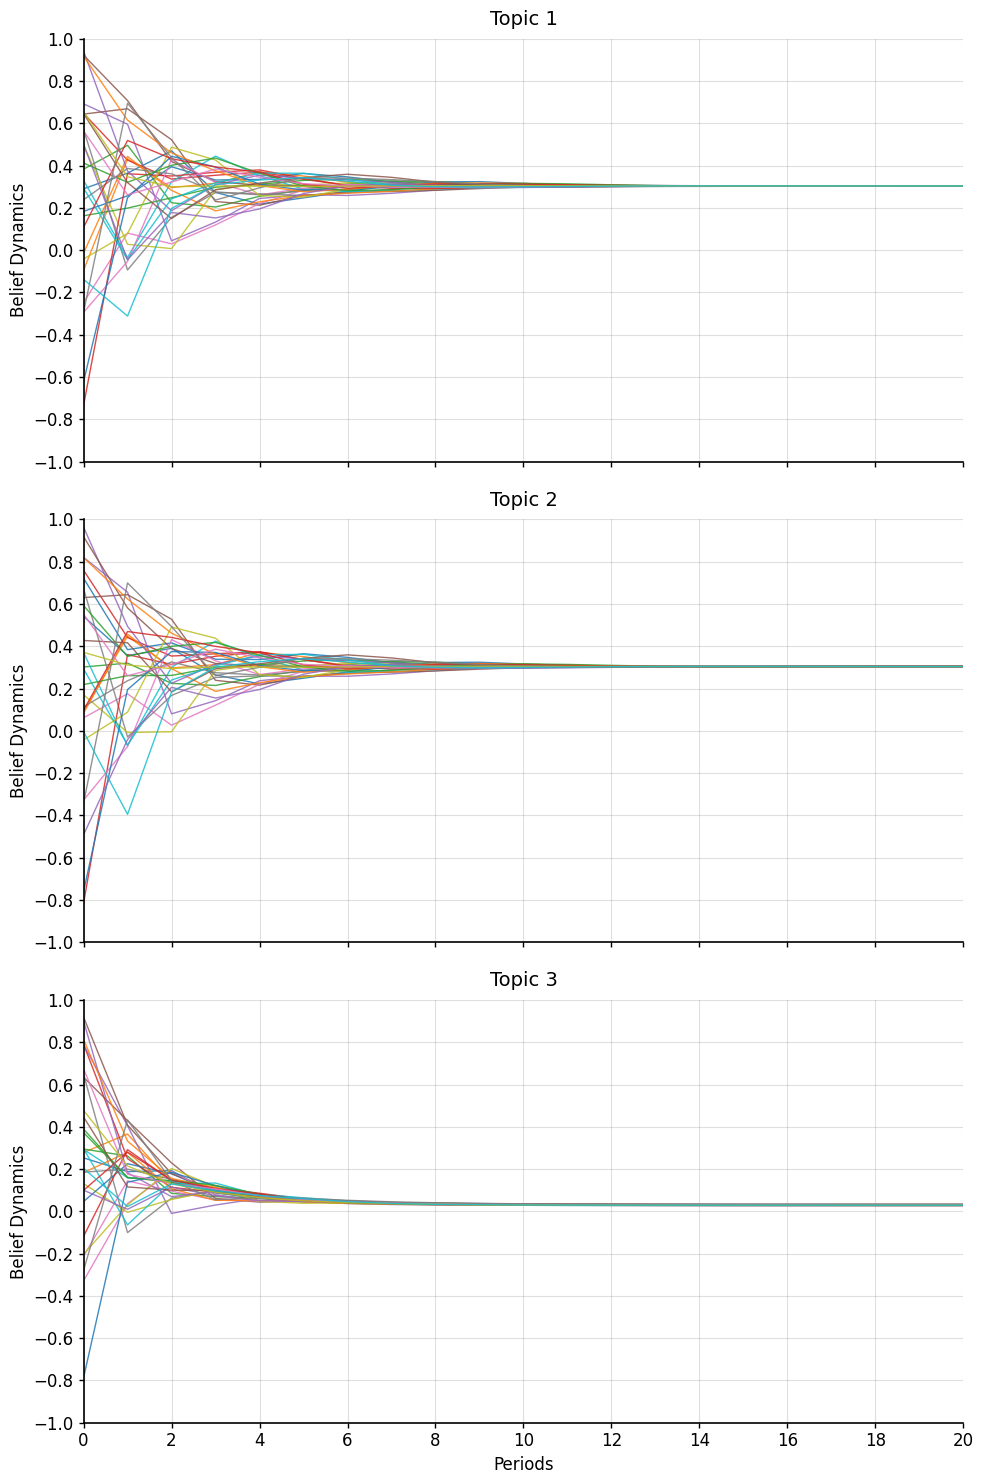

In [9]:

trajectory = simulate(W_matrix, C_tensor, X0_vector, T=T)
print(f"Simulation complete: trajectory shape = {trajectory.shape}")
plot_trajectories(trajectory, m=topic_num, )
